# Project 5 prediction of prices auto.ru

## Importing modules and load data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas.api.types as at
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from tqdm.notebook import tqdm
import xgboost as xgb
from catboost import CatBoostRegressor
import re
from datetime import datetime
from gensim.models import Word2Vec # text vectorizing
from sklearn.cluster import DBSCAN # text clustering
from sklearn.cluster import KMeans # text clustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE # # t-SNE – метод понижения размерности

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42

/Users/alex/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
test = pd.read_csv('test.csv')
mar14 = pd.read_csv('autoru_14mar2021_remastered.csv')
mar14 = mar14.drop(['Unnamed: 0'], axis=1)
display(test.sample(3))
display(mar14.sample(3))

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
22937,внедорожник 5 дв.,LEXUS,https://auto.ru/cars/used/sale/lexus/rx/108210...,серебристый,NaN,"Продаю автомобиль ,в очень хорошем состоянии ....",3.5 LTR,276 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,ALLROAD_5_DOORS AUTOMATIC 3.5,автоматическая,JAPANESE,2 владельца,5 лет и 9 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен
1636,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/karoq/110...,серый,"{""id"":""21786167"",""name"":""Ambition"",""available_...",Состояние нового автомобиля. Хорошая комплекта...,1.4 LTR,150 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,ALLROAD_5_DOORS AUTOMATIC 1.4,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
9269,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x3/10989797...,красный,NaN,Обслуженная машина все работает \nПокупали в р...,2.0 LTR,177 N12,NaN,дизель,...,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,полный,Левый,Не требует ремонта,Растаможен


,Price,bodyType,brand,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,Владение,color
7093,970000.0,внедорожник 5 дв.,VOLVO,{'id': '0'},Автомобиль имеет два дополнительных места в ба...,2.4 LTR,185 N12,"{'cruise-control': True, 'wireless-charger': T...",дизель,278000,...,автоматическая,EUROPEAN,3 или более,Оригинал,полный,Левый,1.0,1.0,6 лет и 6 месяцев,черный
14808,827000.0,внедорожник 5 дв.,NISSAN,{'id': '0'},"Все автомобили, для Вашего удобства, находятся...",2.0 LTR,141 N12,"{'asr': True, 'alloy-wheel-disks': True, 'ptf'...",бензин,149500,...,вариатор,JAPANESE,1 владелец,Оригинал,передний,Левый,1.0,1.0,NaN,белый
11073,2100000.0,лифтбек,BMW,{'id': '0'},Отличное состояние.все вопросы по телефону.рас...,3.0 LTR,306 N12,"{'engine-proof': True, 'cruise-control': True,...",бензин,120000,...,автоматическая,EUROPEAN,2 владельца,Оригинал,полный,Левый,1.0,1.0,6 месяцев,белый


In [3]:
test['is_test'], mar14['is_test'] = 1, 0

df = pd.concat([test, mar14])## Let's look for missing values

## Let's look for missing values

In [4]:
pd.DataFrame((df[df.is_test == 1].isna().sum(), 
              df[df.is_test == 0].isna().sum()), index=['test', 'train']).T

,test,train
bodyType,0,1
brand,0,0
car_url,0,35686
color,0,0
complectation_dict,28268,0
description,0,1078
engineDisplacement,0,0
enginePower,0,0
equipment_dict,9996,0
fuelType,0,0


## Filing missing values and extract some new features

In [5]:
# I just looked to description and read that it is unique bodytype wagon 3 doors :)
df['bodyType'].fillna('универсал 3 дв.', inplace=True)

# There is not many missings in the data column, we can fill them just with most coomon value 
df['ПТС'].fillna(df.ПТС.value_counts().idxmax(), inplace=True)

df.equipment_dict.fillna('{}', inplace=True)
df['equipment_len'] = df['equipment_dict'].apply(lambda x: len(x))

df['complectation_dict'].fillna('{}', inplace=True)
df['complectation_specified'] = df['complectation_dict'].apply(lambda x: 'yes' if len(x) > 25 else 'no')

df['rich_complectation'] = df['complectation_dict'].apply(lambda x: 'yes' if 'xenon' in x 
                                                          or 'leather' in x else 'no')

df['hybrid'] = df['name'].apply(lambda x: 1 if 'hyb' in x else 0)
# Missing values inside ownership column is about new cars fill it with 0
df['Владение'].fillna('0 месяцев', inplace=True)

# make period of ownership like number of monthes

def ownership_extract(line):
    period = re.findall(r'\d+', line)
    if len(period) == 2:
        return int(period[0]) * 12 + int(period[1])
    elif len(period) == 1:
        return int(period[0])
    
df['Владение'] = df['Владение'].apply(ownership_extract)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70372 entries, 0 to 35685
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bodyType                 70372 non-null  object 
 1   brand                    70372 non-null  object 
 2   car_url                  34686 non-null  object 
 3   color                    70372 non-null  object 
 4   complectation_dict       70372 non-null  object 
 5   description              69294 non-null  object 
 6   engineDisplacement       70372 non-null  object 
 7   enginePower              70372 non-null  object 
 8   equipment_dict           70372 non-null  object 
 9   fuelType                 70372 non-null  object 
 10  image                    34686 non-null  object 
 11  mileage                  70372 non-null  int64  
 12  modelDate                70372 non-null  int64  
 13  model_info               70372 non-null  object 
 14  model_name            

## Data visualization

### for better understanding

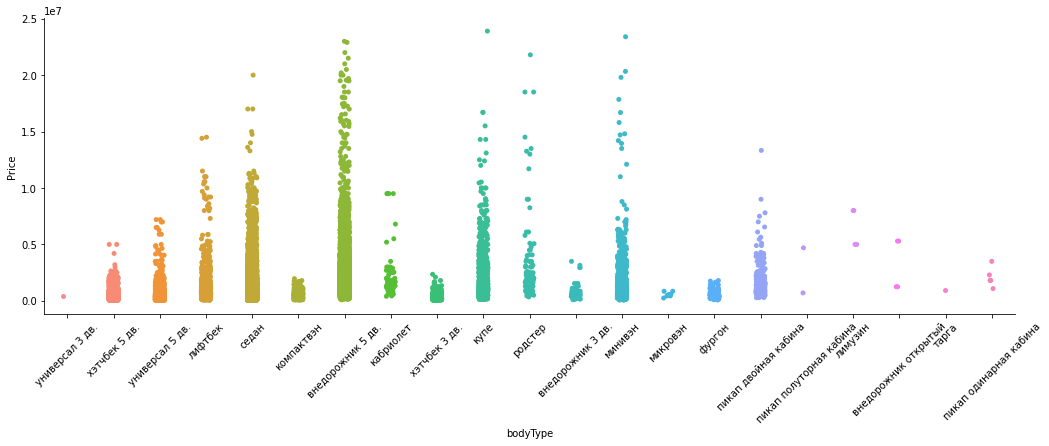

In [7]:
plot = sns.catplot(x='bodyType',
            y='Price',
            data=df[df.is_test == 0])
plot.fig.set_figwidth(20)
# plot.fig.set_figheight(10)
plot.set_xticklabels(rotation=45);

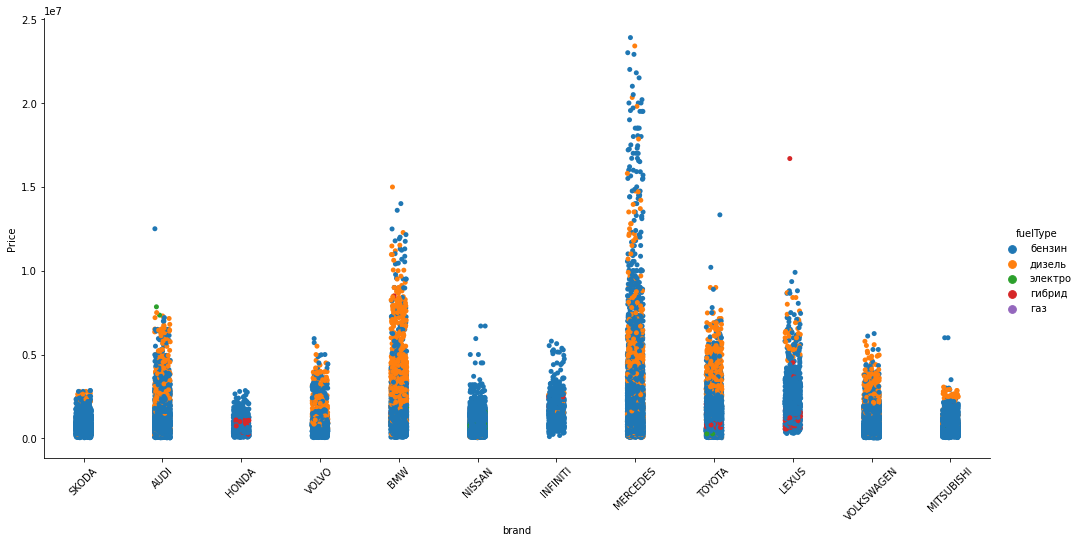

In [8]:
plot = sns.catplot(x='brand', y='Price', hue='fuelType',
                   height = 7, aspect=2,
                   data=df[df.is_test == 0]);
plot.set_xticklabels(rotation=45);

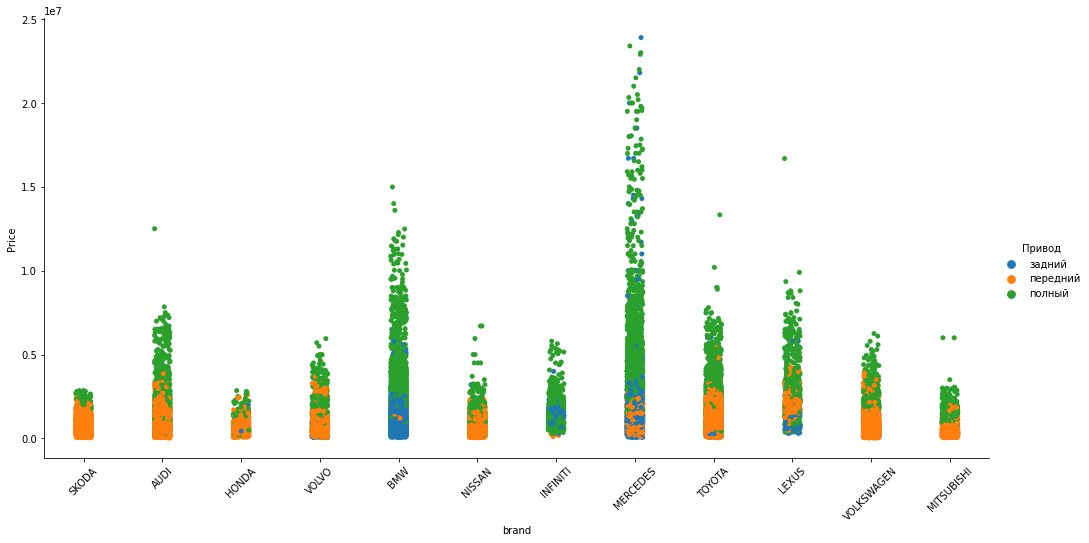

In [9]:
plot = sns.catplot(x='brand', y='Price', hue='Привод',
                   height = 7, aspect=2,
                   data=df[df.is_test == 0]);
plot.set_xticklabels(rotation=45);

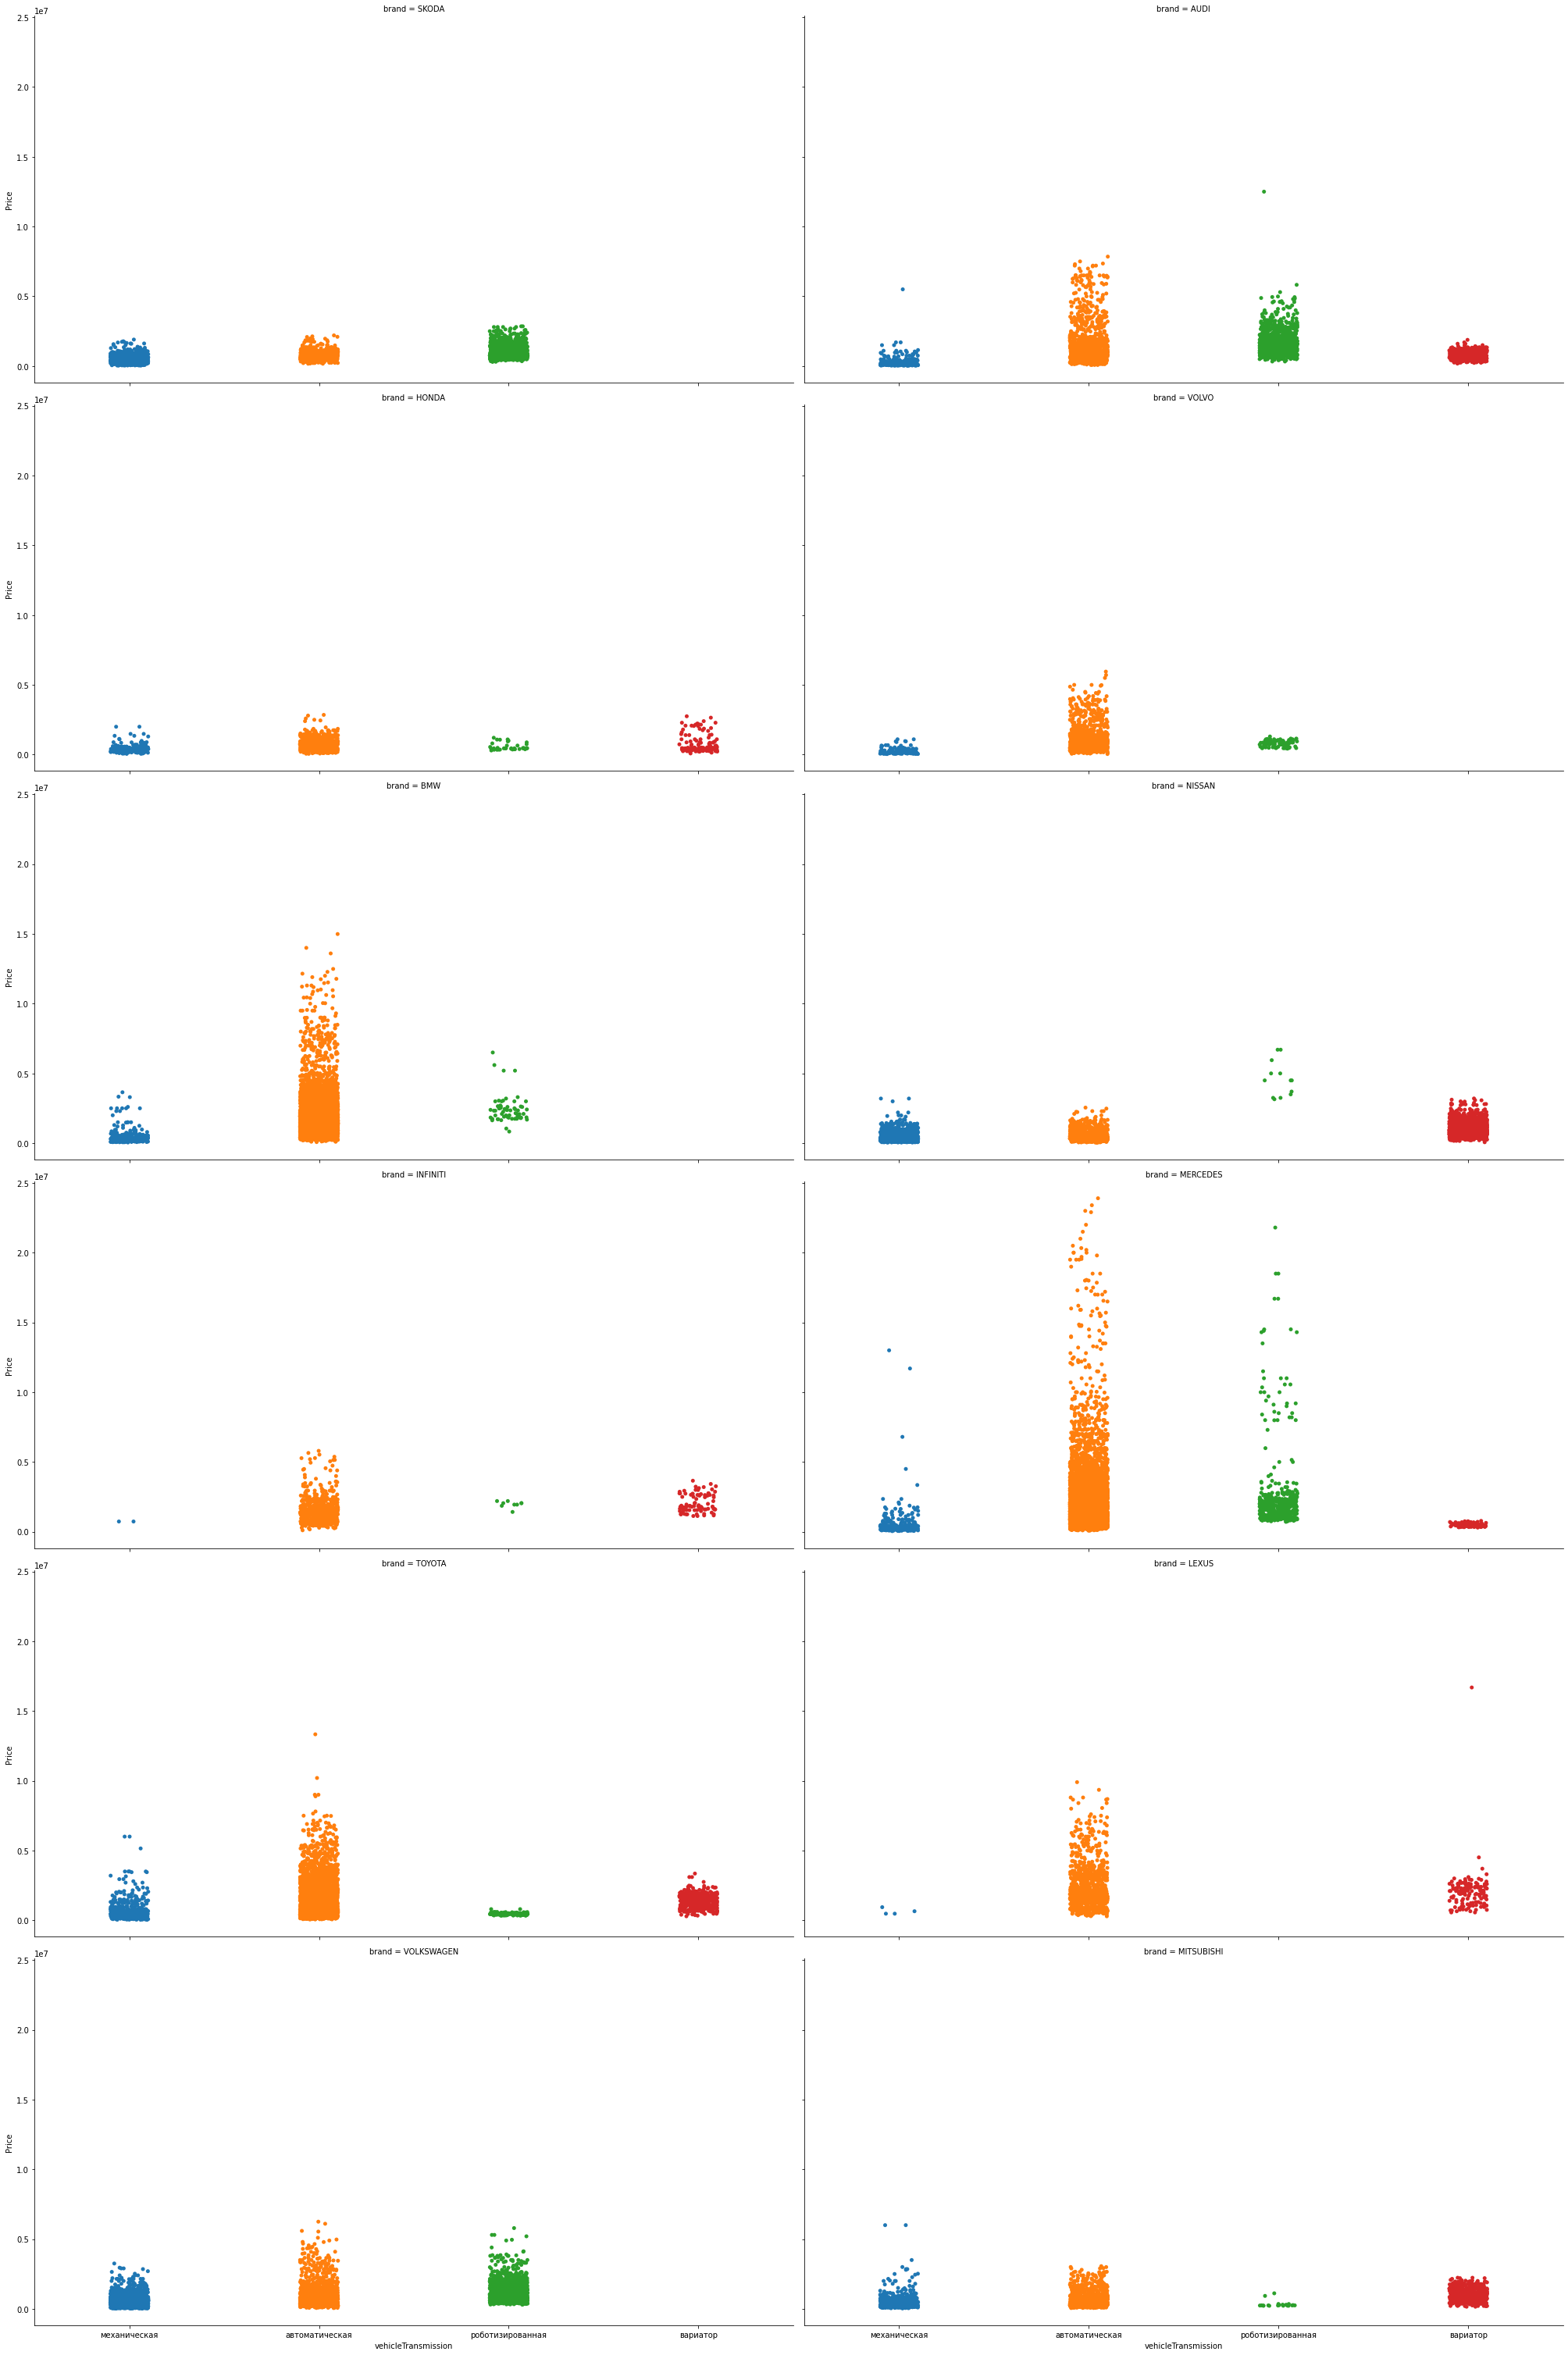

In [10]:
plot = sns.catplot(x='vehicleTransmission', y='Price', col='brand', 
                   height = 7, aspect=2, col_wrap=2,
                   data=df[df.is_test == 0]);
# plot.set_xticklabels(rotation=45);

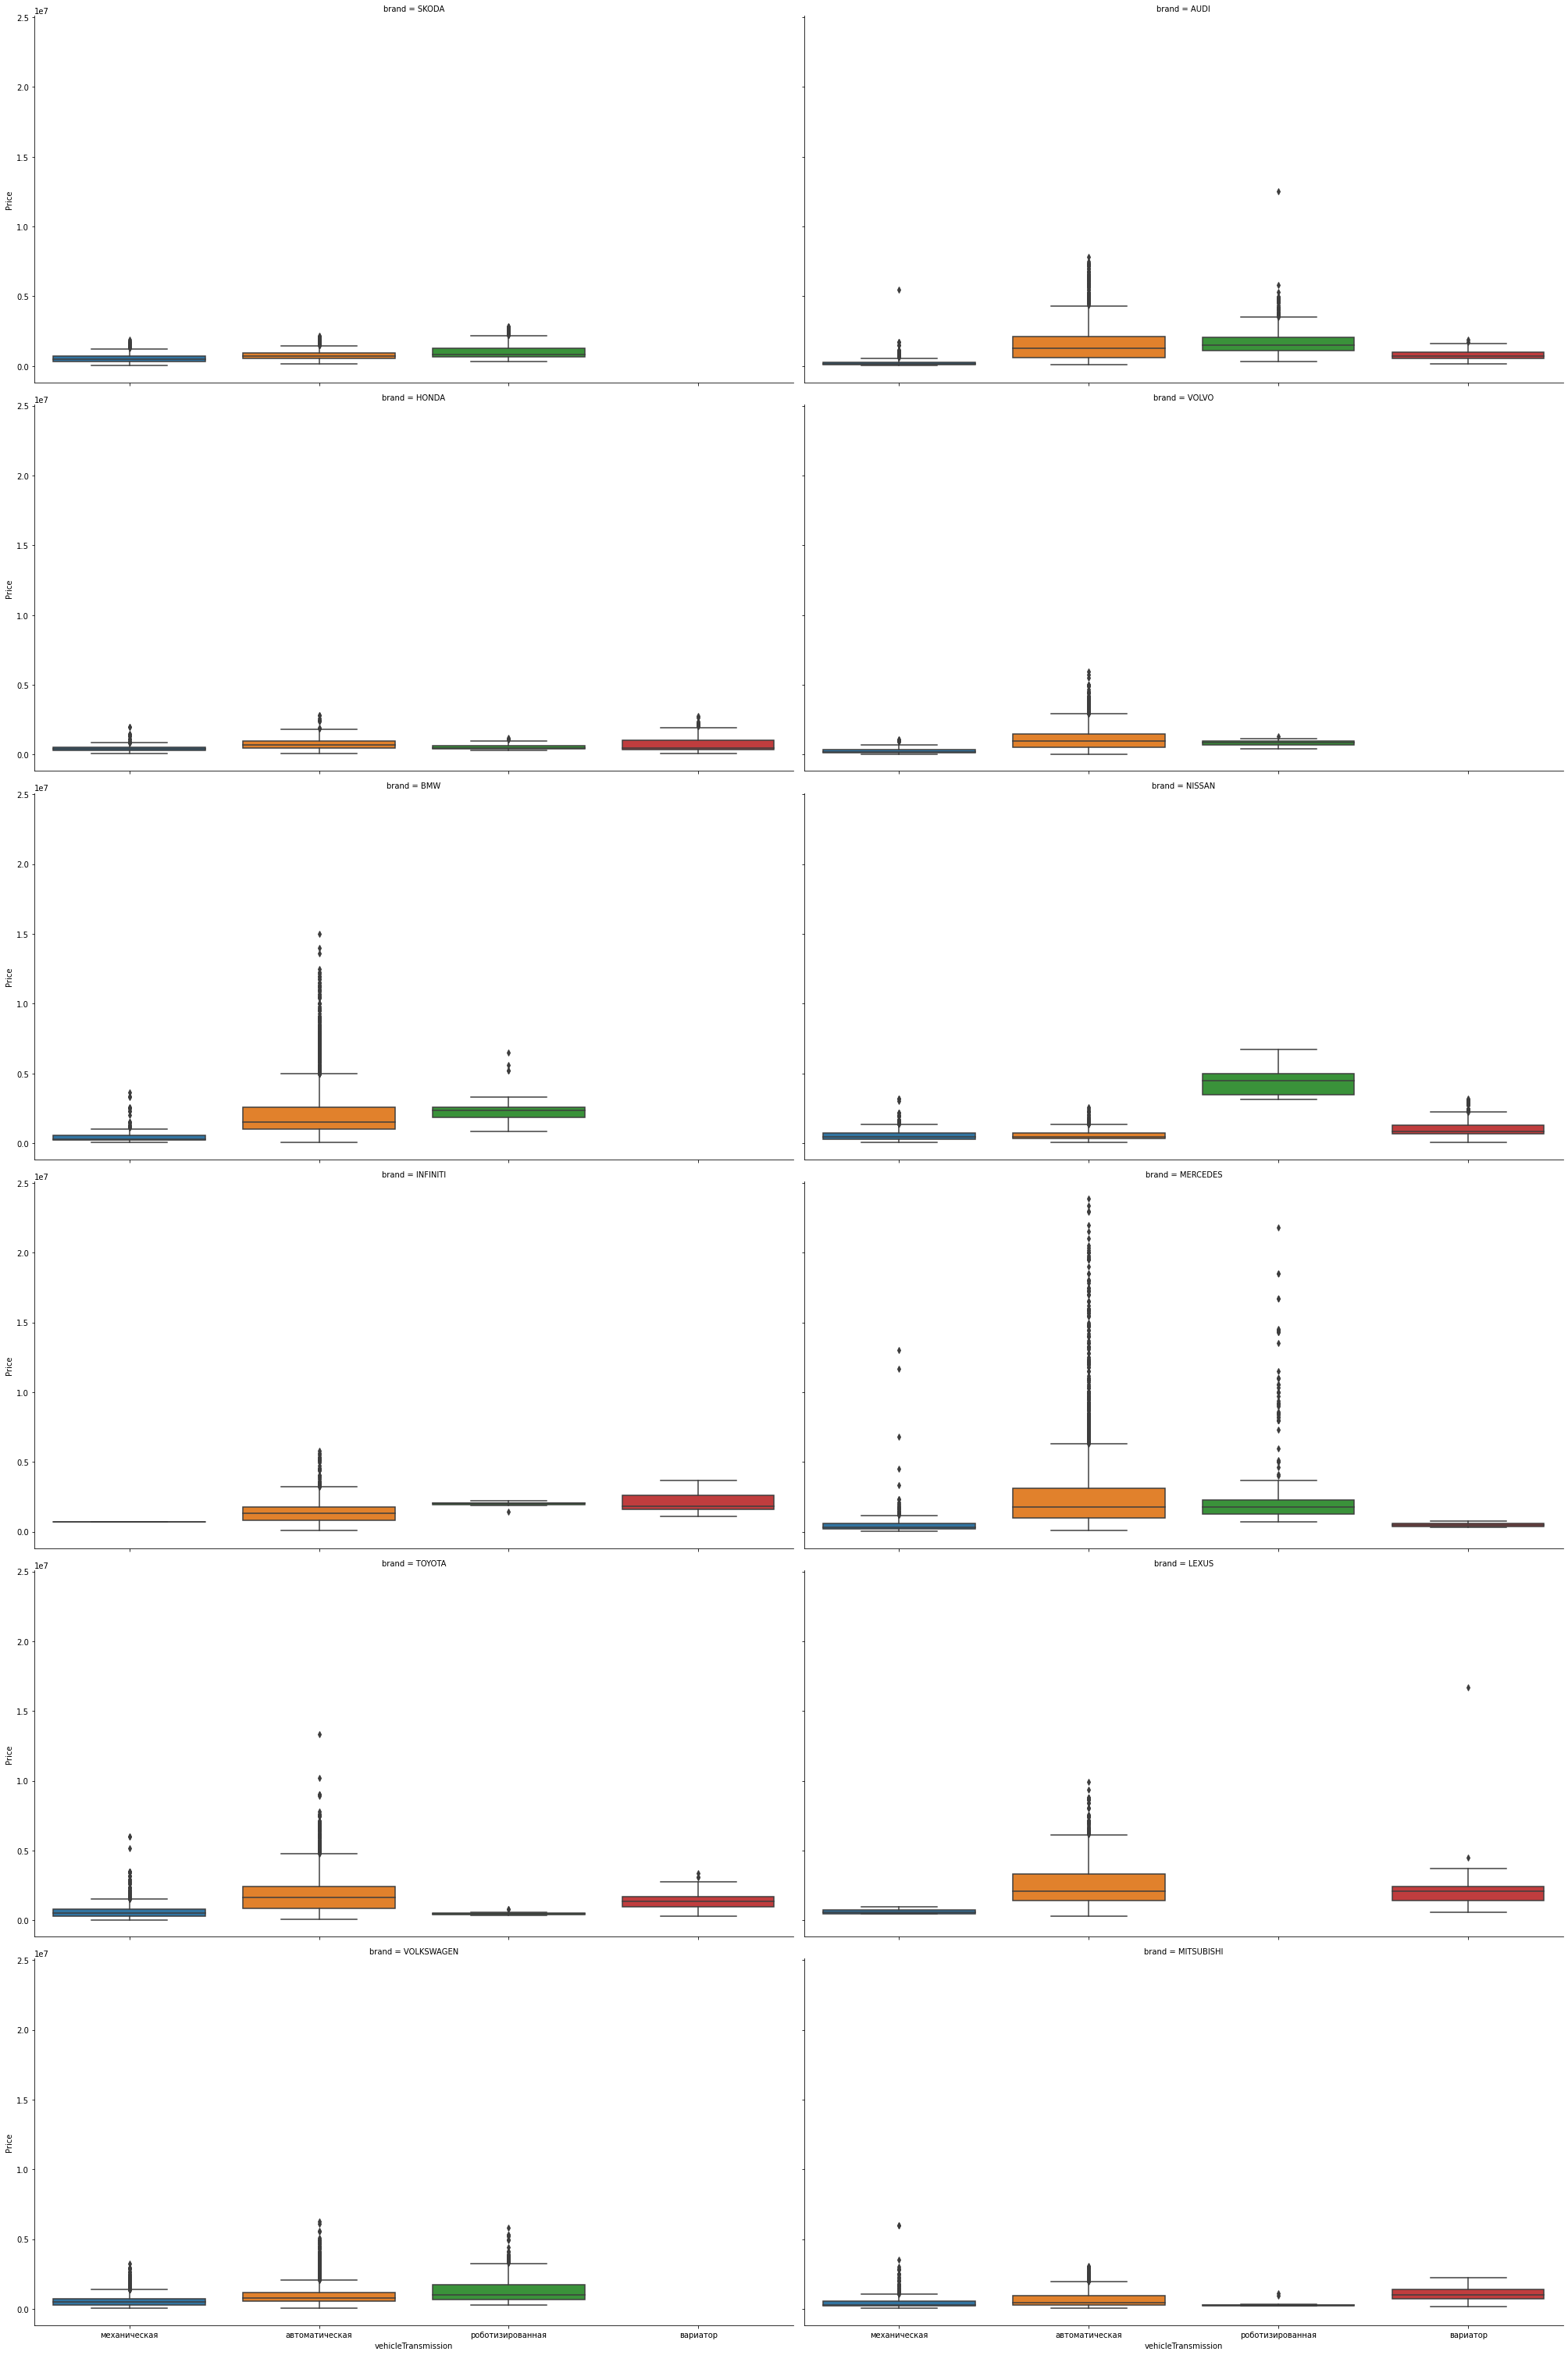

In [11]:
plot = sns.catplot(x='vehicleTransmission', y='Price', col='brand', 
                   height = 7, aspect=2, col_wrap=2, kind='box',
                   data=df[df.is_test == 0]);
# plot.set_xticklabels(rotation=45);

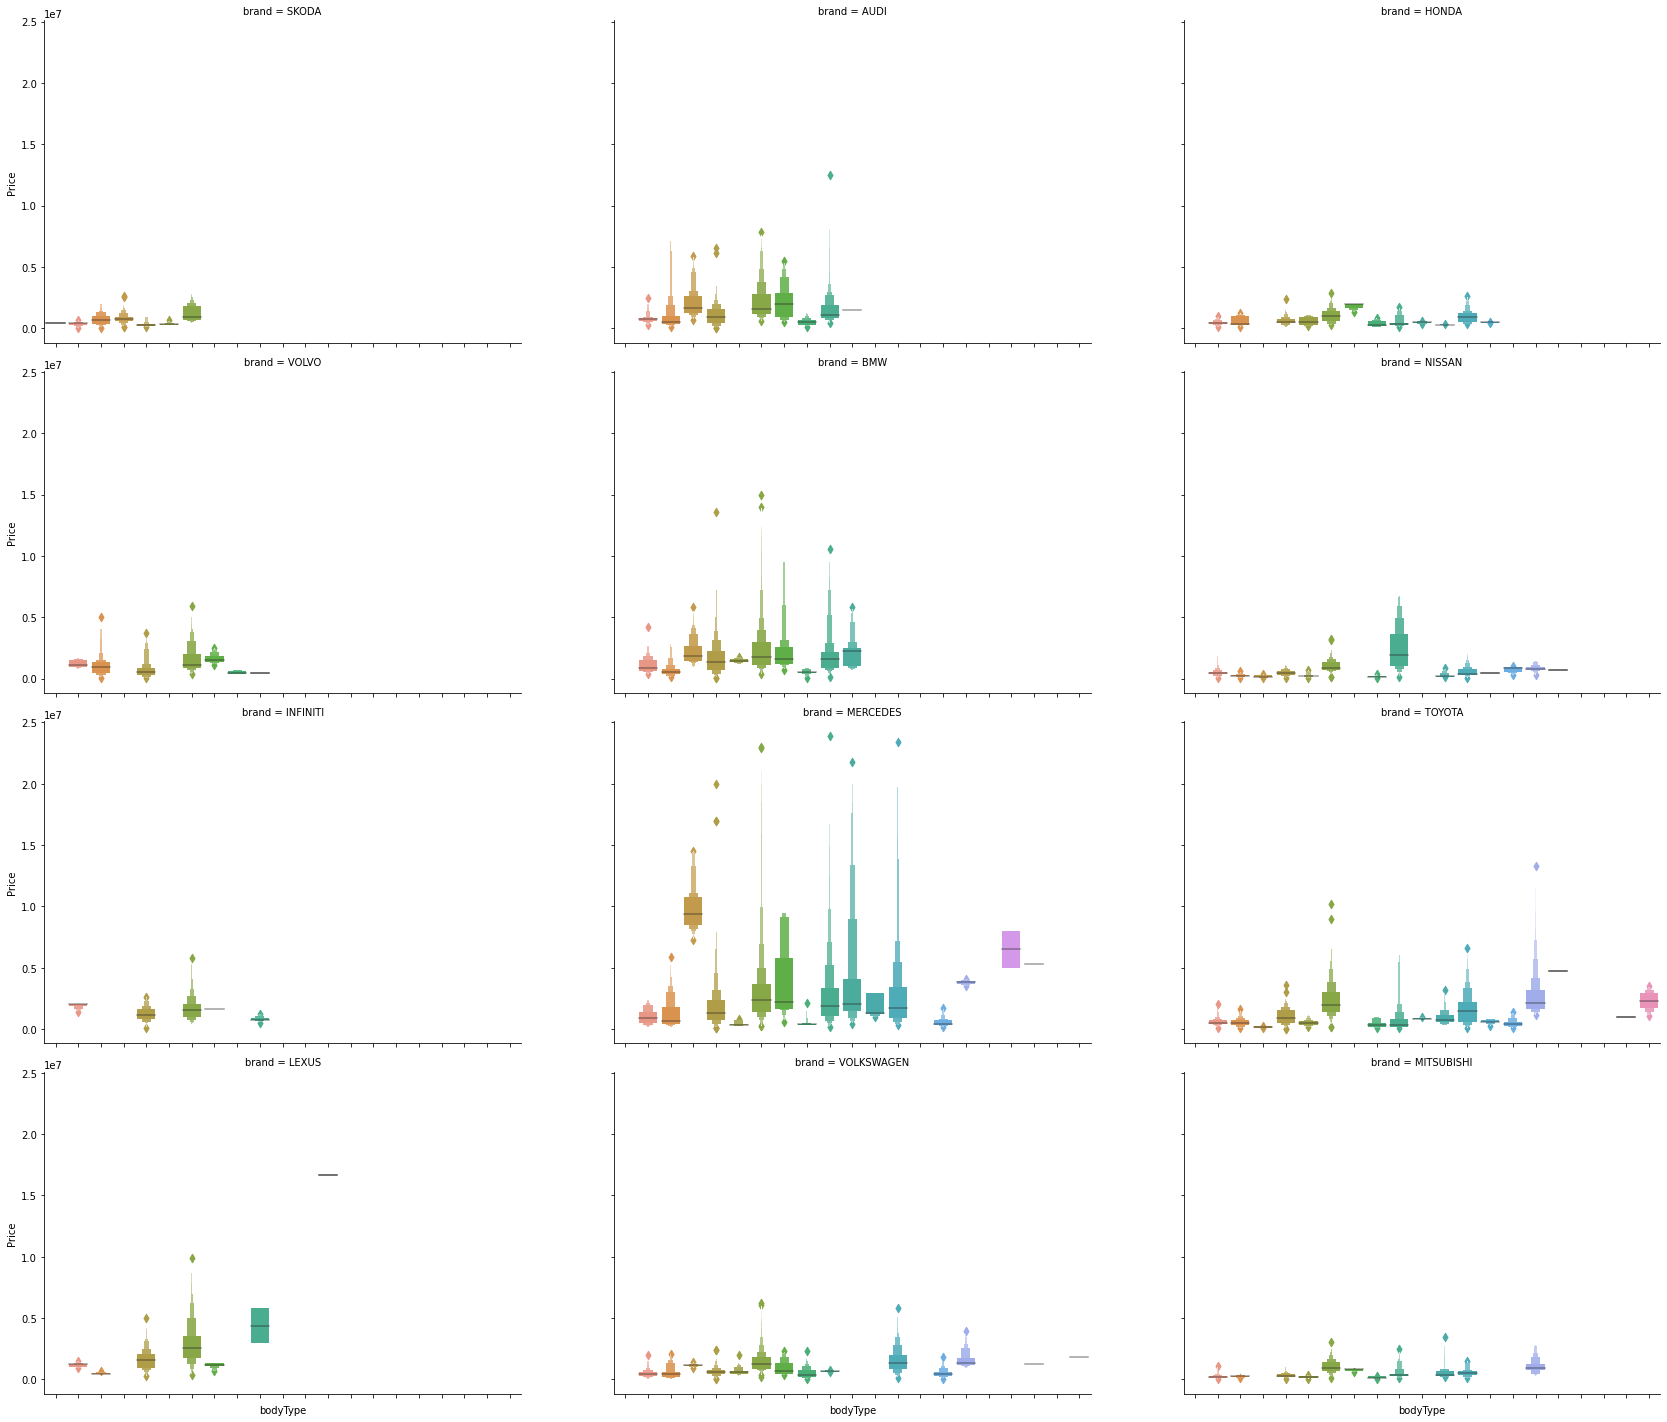

In [12]:
plot = sns.catplot(x='bodyType', y='Price', col='brand',
                   height = 5, aspect=1.6,
                   kind='boxen', col_wrap=3,
                   data=df[df.is_test == 0]);
plot.set_xticklabels(rotation=45);

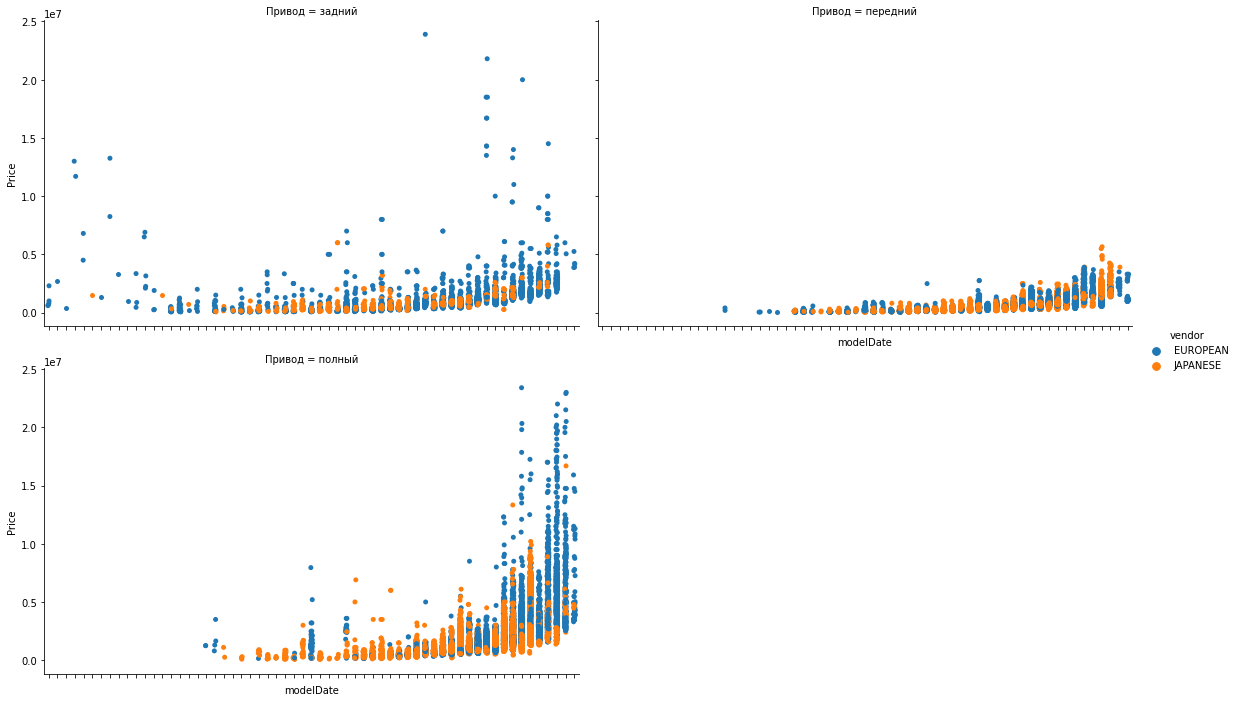

In [13]:
plot = sns.catplot(x='modelDate', y='Price', col='Привод', hue='vendor',
                   height = 5, aspect=1.6,
                   col_wrap=2,
                   data=df[df.is_test == 0]);
plot.set_xticklabels(rotation=45);

## Work with data

### After quik look into the description i realized we can recognize dillers by their common words. 
### Lets make binary column about it

In [14]:
df['description'] = df['description'].map(lambda x: str(x).lower())

diller_list = ['кредит', 'выкуп', 'проверенных', 'предлагаем', 'работаем', 'юридическую', 'юридическая',
               'специалистами', 'нашем', 'Трейд-ин', 'кредитованию', 'скидки', 'приглашаем', 'тест-драйв',
               'криминалистическую', 'одобрение', 'онлайн-бронирование', 'лот']

def diller_recognition(line):
    for word in diller_list:
        if word in line:
            return 1
    return 0

df['diller'] = df['description'].apply(diller_recognition)

### let's make the engineDisplacement and enginePower columns to nummerical features

In [15]:
# engineDisplacement

def engine_displacement_to_num(line):
    displacement = re.findall(r'\d\.\d', line)
    if len(displacement) == 0: return 0.0
    else: return float(displacement[0])

df['engineDisplacement'] = df['engineDisplacement'].apply(engine_displacement_to_num)

# enginePower

df['enginePower'] = df['enginePower'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

### The super_gen columns has many useful attributes inside but after extraction i realized that we have about 50% missing values it is too much to work with.

### FYI I put the code below

```python
def displacement_func(line):
    try: return int(re.search(r'"displacement":(\d+)', line)[0][15:-1])
    except: return np.nan

def gear_type_func(line):
    try: return re.search(r'"gear_type":"(\w+)"', line)[0][13:-1]
    except: return np.nan

def acceleration_func(line):
    try: return float(re.search(r'"acceleration":(\d+.\d+)', line)[0][15:])
    except: return np.nan

def clearance_min_func(line):
    try: return int(re.search(r'clearance_min":(\d+)', line)[0][15:])
    except: return np.nan

def fuel_rate_func(line):
    try: return int(re.search(r'fuel_rate":(\d+)', line)[0][11:])
    except: return np.nan

df['displacement'] = df['super_gen'].apply(displacement_func)
df['gear_type'] = df['super_gen'].apply(gear_type_func)
df['acceleration'] = df['super_gen'].apply(acceleration_func)
df['clearance_min'] = df['super_gen'].apply(clearance_min_func)
df['fuel_rate'] = df['super_gen'].apply(fuel_rate_func)

df[['displacement', 'gear_type', 'acceleration', 'clearance_min', 'fuel_rate']].isna().sum() / len(df)


>>> displacement     0.507887
    gear_type        0.507105
    acceleration     0.575783
    clearance_min    0.520619
    fuel_rate        0.556500
    dtype: float64
```

### Vectorizing description column

In [16]:
description = df.description.to_list()

# Creating an object that will tokenize the data
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Tokenizing data
docs = []
for document in description:
    docs.append(analyzer(document.replace('_', '')))

# Let's have a look at the first example
print(docs[0])

['все', 'автомобили', 'представленные', 'продаже', 'проходят', 'тщательную', 'проверку', 'по', 'более', '40', 'параметрам', 'предоставляем', 'гарантию', 'юридической', 'чистоты', 'так', 'же', 'год', 'технической', 'гарантии', 'на', 'двигатель', 'кпп', 'бесплатный', 'тест', 'драйв', 'возможно', 'оформление', 'автомобиля', 'кредит', 'преимущества', 'автокредитования', 'первоначальный', 'взнос', 'от', 'более', '30', 'кредитных', 'программ', 'процентная', 'ставка', 'от', 'годовых', 'срок', 'кредита', 'от', 'месяцев', 'до', 'лет', 'оформление', 'кредита', 'по', 'двум', 'документам', 'досрочное', 'погашение', 'без', 'штрафов', 'комиссий', 'сумма', 'кредита', 'до', 'млн', 'рублей', 'оформление', 'каско', 'по', 'желанию', 'без', 'справок', 'поручителей', 'сотрудничаем', '12', 'аккредитованными', 'сертифицированными', 'банками', 'рф', 'среднее', 'время', 'ожидания', 'решения', 'банка', '20', '30', 'минут', 'при', 'покупке', 'автомобиля', 'по', 'программе', 'trade', 'выгодный', 'обмен', 'или', '

In [17]:
# manually unified some data

to_look = [1507, 5000, 12391, 19599, 24707, 25566, 32423, 34018, 34170, 43690, 62725, 63053, 63621]

for i in range(len(docs)):
    if len(docs[i]) < 1:
        docs[i] = 'nan'

for i in to_look:
    docs[i] = 'nan'

In [18]:
# Training the vectorizer model on our dataset
# The output will be a feature vector for each word

model = Word2Vec(docs, min_count=20, size=20)

# Naive approach for creating a single embedding for a document – average embedding by words

def doc_vectorizer(doc, model):
    doc_vector, num_words = [], 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model[word]
            else:
                doc_vector = np.add(doc_vector, model[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Make embeddings for our documents
vector_docs = []
for doc in docs:
    vector_docs.append(doc_vectorizer(doc, model))

In [19]:
# Check the vector size for the document
print(np.asarray(vector_docs).shape)

(70372, 20)


In [20]:
# Creating an object to execute t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)

# Transform our data by lowering the dimension from 50 to 2
vector_docs_2_dim = tsne.fit_transform(vector_docs)

print(np.asarray(vector_docs_2_dim).shape)

(70372, 2)


### Clustering text

In [21]:
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan.fit(vector_docs_2_dim)
y_pred_db = dbscan.labels_.astype(np.int)

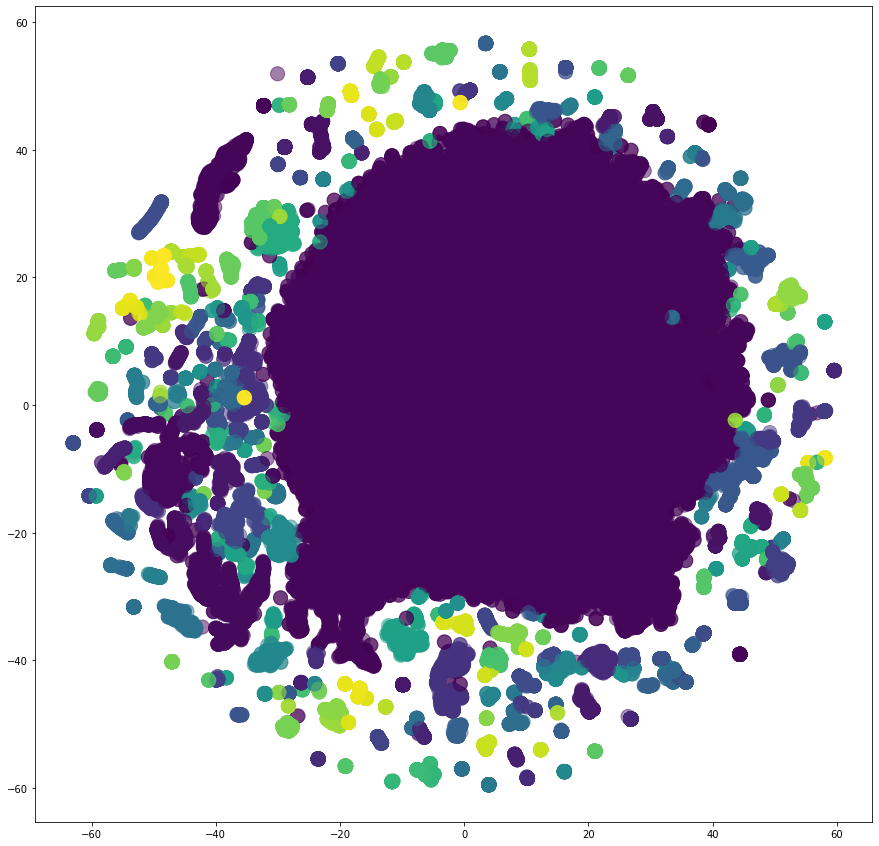

In [22]:
# plots of the received clusters
plt.rcParams['figure.figsize'] = 15, 15
plt.scatter(vector_docs_2_dim[:, 0], vector_docs_2_dim[:, 1], c=y_pred_db, s=200, alpha=.5)
# plt.scatter(dbscan.cluster_centers_[:, 0], dbscan.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

In [23]:
kmeans = KMeans(n_clusters=10)

# Обучаем кластеризатор на подготовленных данных
kmeans.fit(vector_docs_2_dim)

# Получаем предсказанные кластеры
y_pred_km = kmeans.labels_.astype(np.int)

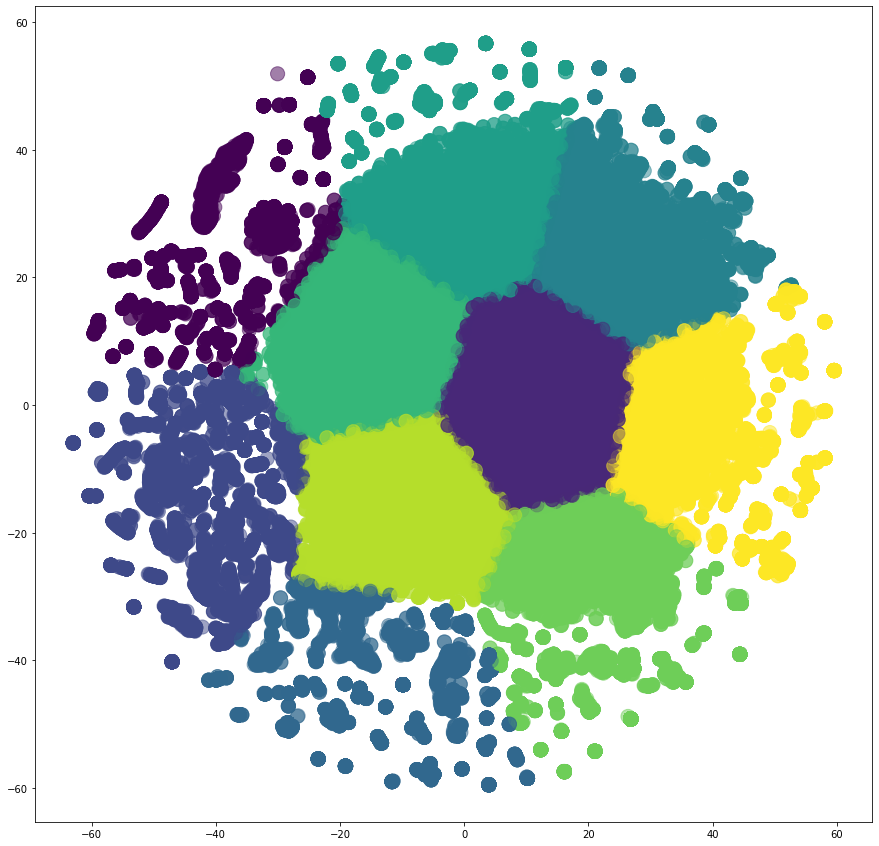

In [24]:
# Graphs of the received clusters
plt.rcParams['figure.figsize'] = 15, 15
plt.scatter(vector_docs_2_dim[:, 0], vector_docs_2_dim[:, 1], c=y_pred_km, s=200, alpha=.5)
# plt.scatter(dbscan.cluster_centers_[:, 0], dbscan.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

In [25]:
df['description_vec'] = y_pred_db

In [26]:
df['description_vec_km'] = y_pred_km

## Let's Rock!

In [27]:
# setup

VERSION     = 3
VAL_SIZE    = 0.33   # 33%
N_FOLDS     = 5

# CATBOOST
ITERATIONS  = 5000
LR          = 0.1
RANDOM_SEED = 42

In [28]:
df_for_model = df.drop(['complectation_dict', 'description', 'equipment_dict', 'model_info', 'car_url',
              'parsing_unixtime', 'super_gen', 'image', 'priceCurrency', 'Состояние', 'Таможня'], axis=1)

In [29]:
df_for_model['brand_engD'] = df_for_model.brand + df_for_model.engineDisplacement.astype('str')
df_for_model['brand_fuel'] = df_for_model.brand + df_for_model.fuelType
df_for_model['brand_transmission'] = df_for_model.brand + df_for_model.vehicleTransmission

In [30]:
df_for_model.sample(1)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,...,equipment_len,complectation_specified,rich_complectation,hybrid,diller,description_vec,description_vec_km,brand_engD,brand_fuel,brand_transmission
9783,седан,BMW,черный,2.0,245,бензин,61500,2009,5ER,528i xDrive 2.0 AT (245 л.с.) 4WD,...,1748,no,no,0,0,4,8,BMW2.0,BMWбензин,BMWавтоматическая


In [31]:
def sort_features(df_raw, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col):
    for col in df_raw.columns:
        if col in target_cols or col in time_cols or col in num_cols\
            or col in bin_cols or col in cat_cols or col in count_col:
            continue
        elif len(df_raw[col].value_counts()) == 1:
                df_raw.drop(columns=[col], inplace=True)
        elif at.is_datetime64_any_dtype(df_raw[col]):
            time_cols.append(col)
        elif at.is_numeric_dtype(df_raw[col]):
            if len(df_raw[col].value_counts()) == 2:
                bin_cols.append(col)
            else: num_cols.append(col)
        elif at.is_string_dtype(df_raw[col]):
            cat_cols.append(col)
        else: print(f'Столбец {col} не был причислен ни к одной категории\n'+'_'*50)

    print_cols_lists(df_raw, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col)

    return target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col

def print_cols_lists(df, target_cols, time_cols, num_cols, bin_cols, cat_cols, count_col):
    print('\nКлючевые признаки: ', target_cols)    
    print('\nПризнаки даты или времени: ', time_cols)    
    print('\nКатегориальные признаки: ', cat_cols)    
    print('\nБинарные признаки: ', bin_cols)    
    print('\nКоличественные признаки: ', num_cols)    
    print('\nПризнаки-счетчики: ', count_col)    

    print('\nВ датасете: строк - ', len(df), 'колонок - ', len(df.columns))

target_cols = ['Price']
num_cols, bin_cols, cat_cols, time_cols, count_col = [], [], [], [], []

target_cols,time_cols,num_cols,bin_cols,cat_cols,count_col = sort_features(df_for_model
                                                                           ,target_cols,time_cols
                                                                           ,num_cols,bin_cols
                                                                           ,cat_cols,count_col)


Ключевые признаки:  ['Price']

Признаки даты или времени:  []

Категориальные признаки:  ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'name', 'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'complectation_specified', 'rich_complectation', 'brand_engD', 'brand_fuel', 'brand_transmission']

Бинарные признаки:  ['is_test', 'hybrid', 'diller']

Количественные признаки:  ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'sell_id', 'Владение', 'equipment_len', 'description_vec', 'description_vec_km']

Признаки-счетчики:  []

В датасете: строк -  70372 колонок -  33


In [32]:
for column in cat_cols:
    df_for_model[column] = df_for_model[column].astype('category')
    df_for_model[column] = df_for_model[column].cat.codes

scaler = MinMaxScaler()
df_for_model[num_cols] = scaler.fit_transform(df_for_model[num_cols])

df_for_model.head(1)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,...,equipment_len,complectation_specified,rich_complectation,hybrid,diller,description_vec,description_vec_km,brand_engD,brand_fuel,brand_transmission
0,8,8,16,0.181818,0.155063,0,0.073999,0.939655,330,44,...,0.269272,0,0,0,1,0.003021,0.444444,194,30,32


### FYI to get some additional polynomial features was unsuccessfull
```python
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(df_for_model[['mileage', 'modelDate', 'productionDate']])
poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names(['mileage', 'modelDate', 'productionDate']))
poly_df.shape

poly_df.drop(['mileage', 'modelDate', 'productionDate'], axis=1, inplace=True)
df_for_model = df_for_model.join(poly_df)

poly_df.sample(3)

num_cols += poly.get_feature_names(['mileage', 'modelDate', 'productionDate'])
num_cols.remove('mileage')
num_cols.remove('modelDate')
num_cols.remove('productionDate')
```

In [33]:
scaler = MinMaxScaler()
df_for_model[num_cols] = scaler.fit_transform(df_for_model[num_cols])

df_for_model.head(1)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,name,...,equipment_len,complectation_specified,rich_complectation,hybrid,diller,description_vec,description_vec_km,brand_engD,brand_fuel,brand_transmission
0,8,8,16,0.181818,0.155063,0,0.073999,0.939655,330,44,...,0.269272,0,0,0,1,0.003021,0.444444,194,30,32


### split data

In [34]:
X = df_for_model.query('is_test == 0').drop(['is_test', 'Price'], axis=1)
y = df_for_model.query('is_test == 0')['Price'] 
X_sub = df_for_model.query('is_test == 1').drop(['is_test', 'Price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, 
                                                    shuffle=True, random_state=RANDOM_SEED)

In [35]:
model = CatBoostRegressor(iterations = 1000,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, np.log(y_train),
         cat_features=cat_cols,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0478250	test: 0.0480146	best: 0.0480146 (0)	total: 167ms	remaining: 2m 46s
100:	learn: 0.0108158	test: 0.0111349	best: 0.0111349 (100)	total: 11s	remaining: 1m 37s
200:	learn: 0.0095590	test: 0.0101174	best: 0.0101169 (199)	total: 18.2s	remaining: 1m 12s
300:	learn: 0.0089683	test: 0.0097229	best: 0.0097229 (300)	total: 25.2s	remaining: 58.5s
400:	learn: 0.0085600	test: 0.0095007	best: 0.0095007 (400)	total: 32.4s	remaining: 48.3s
500:	learn: 0.0082490	test: 0.0093229	best: 0.0093220 (498)	total: 39.4s	remaining: 39.3s
600:	learn: 0.0079711	test: 0.0091946	best: 0.0091946 (600)	total: 46.9s	remaining: 31.1s
700:	learn: 0.0077381	test: 0.0090933	best: 0.0090933 (700)	total: 54.7s	remaining: 23.3s
800:	learn: 0.0075390	test: 0.0090078	best: 0.0090078 (800)	total: 1m 3s	remaining: 15.8s
900:	learn: 0.0073636	test: 0.0089450	best: 0.0089450 (900)	total: 1m 11s	remaining: 7.85s
999:	learn: 0.0071929	test: 0.0088917	best: 0.0088917 (999)	total: 1m 19s	remaining: 0us

bestTest = 0

In [ ]:
# bestTest = 0.008891688773

In [36]:
predict_submission = np.exp(model.predict(X_sub))
predict_submission = np.round(predict_submission, -4)
predict_submission

array([ 650000.,  940000.,  940000., ...,  330000., 1530000., 1130000.])

In [ ]:
VERSION = 31
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

## Стеккинг

In [37]:
estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=RANDOM_SEED,
                                                                 n_estimators=800,
                                                                 min_samples_split=5,
                                                                 min_samples_leaf=4,
                                                                 max_features='sqrt',
                                                                 max_depth=9),
                                       n_estimators=3,
                                       n_jobs=1,
                                       random_state=RANDOM_SEED)),
            ('xgb', xgb.XGBRegressor(objective='reg:squarederror',
                                     colsample_bytree=0.5,
                                     learning_rate=0.05,
                                     max_depth=12,
                                     alpha=1,
                                     n_estimators=1000))]

In [43]:
st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator = CatBoostRegressor(iterations = 5000,
                                                                    learning_rate = LR,
                                                                    random_seed = RANDOM_SEED,
                                                                    eval_metric='MAPE',
                                                                    custom_metric=['R2', 'MAE'],
                                                                    silent=True))
                                
st_ensemble.fit(X_train, np.log(y_train)),
predict_ensemble = np.exp(st_ensemble.predict(X_test))

In [44]:
predict_ensemble = np.exp(st_ensemble.predict(X_sub))

predict_ensemble = np.round(predict_ensemble, -3)
predict_ensemble

array([ 691000.,  984000., 1020000., ...,  353000., 1410000., 1180000.])

In [45]:
VERSION = 33
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = predict_ensemble
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,691000.0
1,1100549428,984000.0
2,1100658222,1020000.0
3,1100937408,840000.0
4,1101037972,785000.0
5,1100912634,804000.0
6,1101228730,696000.0
7,1100165896,451000.0
8,1100768262,1994000.0
9,1101218501,826000.0


In [ ]:
17.27030